## Imports

In [1]:
import os
import random
import time
from collections import namedtuple
from copy import deepcopy
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn.functional as F
import torchvision
from albumentations import (
    CenterCrop,
    Compose,
    HorizontalFlip,
    Normalize,
    RandomCrop,
    RandomResizedCrop,
    Resize,
    Rotate,
    VerticalFlip,
)
from albumentations.pytorch import ToTensor
from utils.ranger import Ranger
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.utils import make_grid

In [2]:
from utils.nn_utils import (
    AlbuSingleAttrDataset,
    ContrastiveLossD,
    ContrastiveLossLecun,
    SiameseNetworkDataset,
    get_image,
    make_oneshot_task,
    test_oneshot_cross_entropy,
    test_oneshot_L2,
    test_oneshot_prob_single_neuron,
)
from utils.siamese_net_archs import (
    SiameseNet5LayersDoubleOut2,
    SiameseNetSimpleDoubleOut,
    SiameseNetworkCustom,
    SiameseNetworkPretrainedBackbone,
    SiameseNetworkPretrainedBackboneSigmoid2,
)

from utils.utils import error_plot, performance_metrics

## Load jupyter extension

In [3]:
# %load_ext pycodestyle_magic
# %flake8_on --max_line_length 99
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload
# %autoreload 2

## Parameters

In [4]:
batch_size = bs = 32
im_size = 28
im_crop = 28
# path_to_nn_weights = "data/Pretrained_weights/"
path_to_data = "data/mnist_png/training/"
path_to_valid_data = "data/mnist_png/testing/"

target_attr = "label"
np.random.seed(5)

## Load labels 

In [5]:
def create_labels_df_from_folders(path_to_data, target_attr=target_attr):
    """Scans the folder structure and creates a dataframe with image paths and labels.
    Folder structure:
    - path_to_data
        - 0
            - 1.png
            ...
            - 7.png
        - 1
            - 1001.png
            - ...
        - ...
        - 9
            - 1009.png
            - ...
        
    Args:
        path_to_data - path to folder with subfolders
        target_attr - default labels name
        
    Returns:
        pandas Dataframe, with path column and label column
    """
    subfolders = [f for f in os.scandir(path_to_data) if f.is_dir()]
    d = {}
    for folder in subfolders:
        for file in os.listdir(folder):
            d[os.path.join(folder, file)] = folder.name
    labels_df = pd.DataFrame.from_dict(data=d, orient="index", columns=[target_attr])
    labels_df[target_attr] = labels_df[target_attr].astype(int)
    labels_df = labels_df.reset_index()
    labels_df = labels_df.rename(columns={"index": "path"})
    return labels_df

In [6]:
labels_df = create_labels_df_from_folders(path_to_data)
labels_df.head()

,path,label
0,../../mnist_png/training/0\1.png,0
1,../../mnist_png/training/0\1000.png,0
2,../../mnist_png/training/0\10005.png,0
3,../../mnist_png/training/0\10010.png,0
4,../../mnist_png/training/0\10022.png,0


In [7]:
labels_valid_df = create_labels_df_from_folders(path_to_valid_data)
labels_valid_df.head()

,path,label
0,../../mnist_png/testing/0\10.png,0
1,../../mnist_png/testing/0\1001.png,0
2,../../mnist_png/testing/0\1009.png,0
3,../../mnist_png/testing/0\101.png,0
4,../../mnist_png/testing/0\1034.png,0


###  img_name(path) : label

In [8]:
name_to_attr = {
    x[0]: target_attr + " = " + str(x[1])
    for x in labels_df[["path", target_attr]].values
}
encoder = name_to_attr

In [9]:
valid_name_to_attr = {
    x[0]: target_attr + " = " + str(x[1])
    for x in labels_valid_df[["path", target_attr]].values
}
valid_encoder = valid_name_to_attr
list(valid_encoder.items())[:3]

[('../../mnist_png/testing/0\\10.png', 'label = 0'),
 ('../../mnist_png/testing/0\\1001.png', 'label = 0'),
 ('../../mnist_png/testing/0\\1009.png', 'label = 0')]

## Prepare Data

### Calculate mean and std of all dataset

In [10]:
def normalization_parameter(dataloader):
    mean = 0.0
    std = 0.0
    nb_samples = len(dataloader.dataset)
    for data, *_ in tqdm(dataloader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
    mean /= nb_samples
    std /= nb_samples
    return mean.numpy(), std.numpy()

### calculate mean and std of all our data

In [11]:
%%time
train_transforms_base = Compose([Resize(im_size, im_size), ToTensor()])

all_data = SiameseNetworkDataset(
    label_df=labels_df,
    target_attr=target_attr,
    indexes=labels_df.index.values,
    transform=train_transforms_base,
)

all_loader = DataLoader(all_data, batch_size=bs, shuffle=True)
mean, std = normalization_parameter(all_loader)
print(mean, std)


[0.13066049 0.13066049 0.13066049] [0.30150446 0.30150446 0.30150446]
Wall time: 1min 59s


In [12]:
# mnist train stats
# mean = np.array([0.13057142, 0.13057142, 0.13057142])
# std = np.array([0.28164333, 0.28164333, 0.28164333])

In [13]:
# image net stats
# mean=np.array([0.485, 0.456, 0.406])
# std=np.array([0.229, 0.224, 0.225])

### Check normalization

In [14]:
train_transforms_check = Compose(
    [Resize(im_size, im_size), Normalize(mean, std), ToTensor()]
)

all_data = SiameseNetworkDataset(
    label_df=labels_df,
    target_attr=target_attr,
    indexes=labels_df.index.values,
    transform=train_transforms_check,
)

all_loader = DataLoader(all_data, batch_size=bs, shuffle=True)
new_mean, new_std = normalization_parameter(all_loader)
is_normalize = (
    np.isclose(new_mean, 0, atol=0.01).all() & np.isclose(new_std, 1, atol=0.01).all()
)
assert is_normalize, "mean ~ 0, std ~ 1"

### By default there is a minimum set of transformations

In [15]:
image_transforms = {
    "train": Compose([Resize(im_crop, im_crop), Normalize(mean, std), ToTensor()]),
    "valid": Compose([Resize(im_crop, im_crop), Normalize(mean, std), ToTensor()]),
}

In [16]:
# inverse normalization for image plot

inv_normalize = Normalize(
    mean=-1 * np.divide(mean, std),
    std=1 / std,
    max_pixel_value=1,  # in pytorch tensor values between 0-1
)

## create pytorch datasets and dataloaders

For training a Siamese network, you need to inside one of the batch was balanced to the number of examples of the same class and different classes.
The SiameseNetworkDataset class implements this logic

In [17]:
data = {
    "train": SiameseNetworkDataset(
        label_df=labels_df,
        target_attr=target_attr,
        indexes=labels_df.index.values,
        transform=image_transforms["train"],
    ),
    "valid": SiameseNetworkDataset(
        label_df=labels_valid_df,
        target_attr=target_attr,
        indexes=labels_valid_df.index.values,
        transform=image_transforms["valid"],
    ),
}
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data["train"])
valid_data_size = len(data["valid"])

# Create iterators for the Data loaded using DataLoader module
train_data = DataLoader(data["train"], batch_size=bs, shuffle=True)
valid_data = DataLoader(data["valid"], batch_size=bs, shuffle=True)

## Plot subsamples

In [18]:
def class_plot(data, encoder, inv_normalize=None, n_figures=12):
    """
    Visualize some pairs from siamese dataset
    
    Args:
      data: pytorch dataset, dataset output format:img_0,img_1,label,name0,name1
          img_0,img_1 - numpy arrays
          label - number, 1 - images has same class, 0 - differ
          name0, name1 - str
      encoder : dict, {name : original class of image}
      inv_normalize: albumentation transforms
      n_figures : number of plots
      
    Returns:
      plots with titles
    """
    n_row = int(n_figures / 4)
    fig, axes = plt.subplots(figsize=(28, 10), nrows=n_row, ncols=4)
    for ax in axes.flatten():
        rand_idx = random.randint(0, len(data) - 1)
        (img_0, img_1, label, name0, name1) = data[rand_idx]
        # image is torch tensor
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        img_0 = img_0.numpy().transpose(1, 2, 0)
        img_1 = img_1.numpy().transpose(1, 2, 0)

        if inv_normalize is not None:
            img_0 = inv_normalize(image=img_0)["image"]
            img_1 = inv_normalize(image=img_1)["image"]
        image = np.hstack([img_0, img_1]).clip(0, 1)
        label = int(label)
        if label:
            string_label = "SAME (1): "
        else:
            string_label = "DIFFER(0): "  # encoder[label]
        string_label += encoder[name0] + " | " + encoder[name1]
        ax.imshow(image)
        ax.set_title(string_label)
        ax.axis("off")
    plt.show()

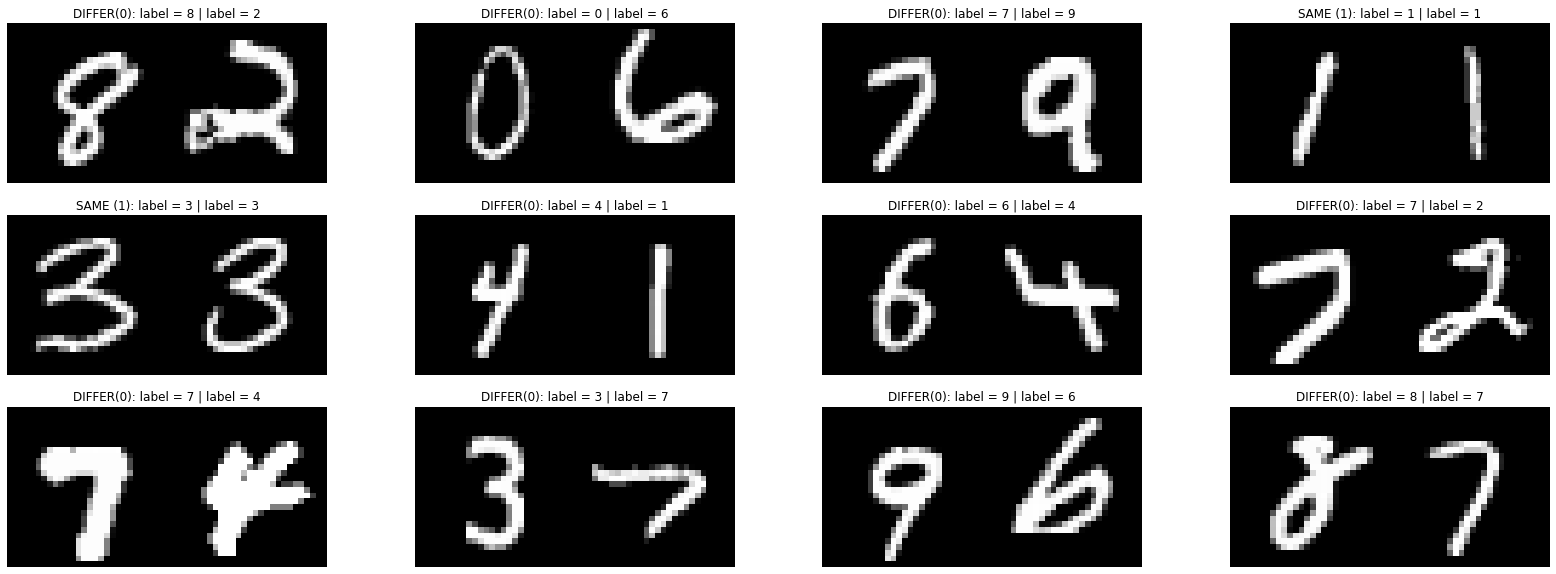

In [19]:
class_plot(data["train"], encoder=encoder, inv_normalize=inv_normalize)

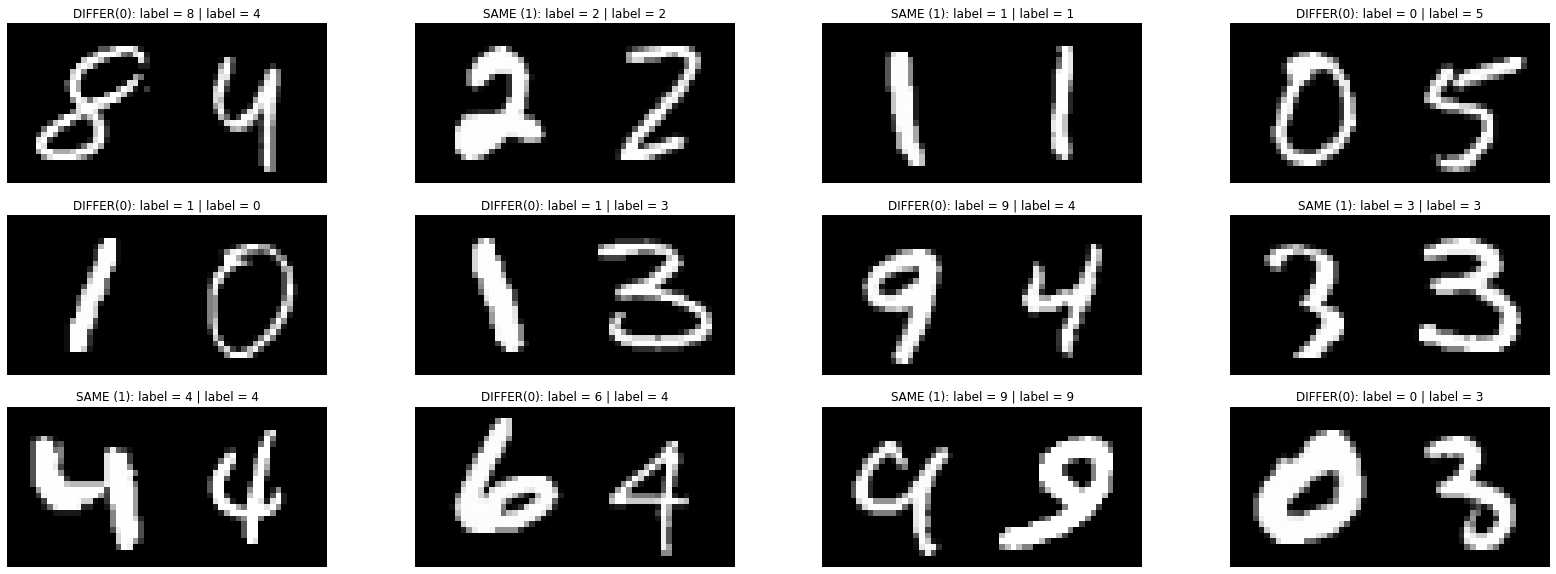

In [20]:
class_plot(data["valid"], encoder=valid_encoder, inv_normalize=inv_normalize)

## define network

In [21]:
print(
    "unique labels in {} attribute:".format(target_attr),
    labels_df[target_attr].unique(),
)
num_classes = len(labels_df[target_attr].unique())
print("num classes in attr:", num_classes)

unique labels in label attribute: [0 1 2 3 4 5 6 7 8 9]
num classes in attr: 10


In [22]:
assert labels_df[target_attr].unique().min() == 0

### One shot test - Siamese network
Note that, for every pair of input images, our model generates a similarity score. But just looking at the score its difficult to ascertain whether the model is really able to recognize similar characters and distinguish dissimilar ones.

A nice way to judge the model is N-way one shot learning.  4-shot-learning
Basically the image is compared to 4 different images out of which only one of them matches the original image. Let’s say by doing the above 4 comparisons we get 4 similarity scores S1, S2, S3 and S4 as shown. Now if the model is trained properly, we expect that S1 is the maximum of all the 4 similarity scores because the first pair of images is the only one where we have two same characters.

- [img_class_X ,img_class_X] - S1
- [img_class_X ,img_class_Y] - S2
- [img_class_X ,img_class_Z] - S3
- [img_class_X ,img_class_Y] - S4  

Thus if S1 happens to be the maximum score, we treat this as a correct prediction otherwise we consider this as an incorrect prediction. Repeating this procedure ‘k’ times, we can calculate the percentage of correct predictions.  

more : https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d  

In [23]:
def img_tensor_plot(image, inv_normalize=None):
    image = image.cpu().numpy().squeeze()
    image = image.transpose(1, 2, 0)
    if inv_normalize is not None:
        augmented = inv_normalize(image=image)
        image = augmented["image"]
    image = image.clip(0, 1)
    plt.imshow(image)
    plt.show()

tensor([0., 0., 1., 0.])


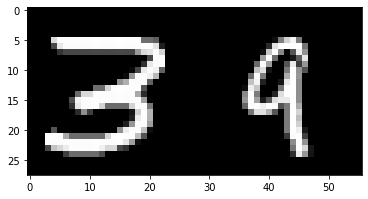

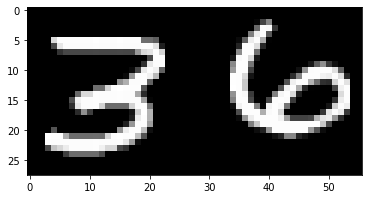

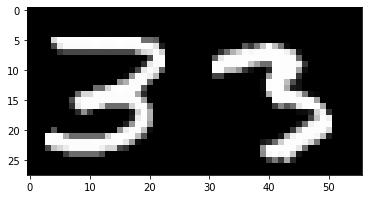

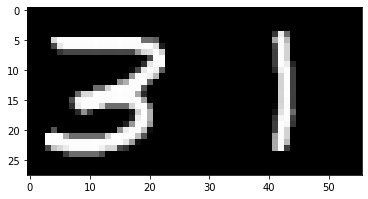

In [24]:
img0a, img1a, targets_a = make_oneshot_task(4, valid_data)
concatenated = torch.cat((img0a, img1a), 3)
print(targets_a)
for i in range(concatenated.size(0)):
    im = concatenated[i].squeeze()
    img_tensor_plot(im, inv_normalize=inv_normalize)

## Train

In [25]:
resnet = torchvision.models.resnet50(pretrained=True)
# state = torch.load(path_to_nn_weights + "resnet50-19c8e357.pth")
# resnet.load_state_dict(state)

# for name, child in resnet.named_children():
#     print(name)

for name, child in resnet.named_children():
    if name in ["fc", "avgpool", "layer4", "layer3"]:
        print(name + " is unfrozen")
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + " is frozen")
        for param in child.parameters():
            param.requires_grad = False

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is unfrozen
layer4 is unfrozen
avgpool is unfrozen
fc is unfrozen


## Consider several approaches to Siamese nets
### Different architectures require the use of different loss functions, and precision counting methods

### Variant 1 
The neural network at the forward pass receives 2 images, the output gives them embeds (2 vectors)  
The loss should take 2 vectors, and calculate the similarity function for them, for example, you can use Euclidean distance (L2), if the images are from the same class, the distance should be as small as possible, the smaller the distance the smaller the loss.

model = SiameseNet5LayersDoubleOut2() or  
model = SiameseNetSimpleDoubleOut()  
loss_func = ContrastiveLossD()  
out_mode = "L2"  

### Variant 2
The neural network at the forward pass receives 2 images, output receives the probability that the images are from same class. This is possible if for example nn has 1 output neuron with sigmoid activation function.
The best variant of the loss function in this case is binary cross entropy.

model3 = SiameseNetworkPretrainedBackbone(deepcopy(resnet), out_act="sigmoid", out_neurons=1)  
loss_func = nn.BCELoss()  
out_mode = "prob_single_neuron"    

### Variant 3 
The neural network at the forward pass receives 2 images, output receives raw logits, number of neurons - number of possible labels, in our case - two output neuron (1 - images are from same class, 0 - for opposite).
We can use crossEntropyLoss in this case

model = SiameseNetworkPretrainedBackbone(deepcopy(resnet), out_act="no_act", out_neurons=2)  
loss_func = nn.CrossEntropyLoss()  
out_mode = "cross_entropy"  

## Define net. Choose variant №1

In [26]:
class SiameseNet5LayersDoubleOut2(nn.Module):
    """This is a simple network for mnist images recognition,
    outputs 2 embedding vectors
    based on:
    https://becominghuman.ai/siamese-networks-algorithm-applications-and-pytorch-implementation-4ffa3304c18
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 7)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.conv3 = nn.Conv2d(128, 256, 5)
        self.linear1 = nn.Linear(2304, 2)

    def forward_once(self, x):
        # Forward pass
        output = self.conv1(x)
        output = F.relu(output)
        output = self.pool1(output)
        output = self.conv2(output)
        output = F.relu(output)
        output = self.conv3(output)
        output = F.relu(output)
        output = output.view(output.shape[0], -1)
        output = self.linear1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

In [27]:
model = SiameseNet5LayersDoubleOut2()
loss_func = ContrastiveLossD()
out_mode = "L2"
test_oneshot_func = test_oneshot_L2

In [28]:
torch.cuda.empty_cache()

### Ranger optimizer

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.00005)
optimizer = Ranger(model.parameters())
# Ranger is new optimizer combined Radam and Lookahead techniques
# https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
scheduler = CosineAnnealingWarmRestarts(optimizer, 5)

device: cuda


### parameters

In [30]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


def eval_f(model):
    with torch.no_grad():
        model.eval()
        avg_acc = test_oneshot_func(
            model, N_way, n_val, valid_data, device, verbose=True
        )
        return avg_acc

In [31]:
counter = []
history = []

In [32]:
EPOCHS = 10
N_way = 50  # how many classes for testing one-shot tasks
n_val = 250  # how many one-shot tasks to validate on

## Train

In [33]:
for epoch in tqdm(range(EPOCHS)):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch + 1, EPOCHS))

    # Set to training mode
    model.train()

    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0

    valid_loss = 0.0
    valid_acc = 0.0

    for i, inputs in tqdm(enumerate(train_data)):

        if i % 400 == 1:
            eval_f(model)
            model.train()
        img0, img1, label, *_ = inputs
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)
        if out_mode == "cross_entropy":
            label = label.type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        output = model(img0, img1)

        if isinstance(output, tuple):
            output1 = output[0]
            output2 = output[1]
            loss = loss_func(output1, output2, label)
        else:
            loss = loss_func(output, label)
        if torch.isnan(loss).any():
            raise ValueError("loss is nan")
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * img0.size(0)

    scheduler.step()
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, inputs in enumerate(valid_data):
            img0, img1, label, *_ = inputs
            img0, img1, label = img0.to(device), img1.to(device), label.to(device)
            if out_mode == "cross_entropy":
                label = label.type(torch.LongTensor).to(device)
            output = model(img0, img1)

            if isinstance(output, tuple):
                output1 = output[0]
                output2 = output[1]
                loss = loss_func(output1, output2, label)
            else:
                loss = loss_func(output, label)

            # Compute the total loss for the batch and add it to valid_loss
            valid_loss += loss.item() * img0.size(0)

        # Find average training loss and training accuracy
        avg_train_loss = train_loss / train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss / valid_data_size

        avg_valid_acc = eval_f(model)

        history.append([avg_train_loss, avg_valid_loss, avg_valid_acc])

        epoch_end = time.time()

        print("Epoch : {:03d},\nTraining  : Loss: {:.4f}".format(epoch, avg_train_loss))
        print(
            "Validation: Loss: {:.4f}, Accuracy: {:.1f}%:,\n\t Time: {:.4f}s".format(
                avg_valid_loss, avg_valid_acc, epoch_end - epoch_start
            )
        )

Epoch: 1/10


Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 4.8% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 61.2% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 66.0% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 84.8% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 87.6% 50 way one-shot learning accuracy 


Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 90.4% 50 way one-shot learning accuracy 

Epoch : 000,
Training  : Loss: 0.0410
Validation: Loss: 0.0242, Accuracy: 90.4%:,
	 Time: 153.5625s
Epoch: 2/10


Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 88.4% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 89.6% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 93.6% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 92.4% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 96.8% 50 way one-shot learning accuracy 


Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 96.8% 50 way one-shot learning accuracy 

Epoch : 001,
Training  : Loss: 0.0195
Validation: Loss: 0.0160, Accuracy: 96.8%:,
	 Time: 146.0578s
Epoch: 3/10


Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 96.4% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 97.2% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 97.2% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 93.6% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 96.4% 50 way one-shot learning accuracy 


Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 97.2% 50 way one-shot learning accuracy 

Epoch : 002,
Training  : Loss: 0.0123
Validation: Loss: 0.0136, Accuracy: 97.2%:,
	 Time: 145.8861s
Epoch: 4/10


Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 96.0% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 98.4% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 99.2% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 97.2% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 98.4% 50 way one-shot learning accuracy 


Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 98.4% 50 way one-shot learning accuracy 

Epoch : 003,
Training  : Loss: 0.0081
Validation: Loss: 0.0095, Accuracy: 98.4%:,
	 Time: 145.7767s
Epoch: 5/10


Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 94.0% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 97.2% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 98.0% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 98.0% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 99.2% 50 way one-shot learning accuracy 


Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 98.4% 50 way one-shot learning accuracy 

Epoch : 004,
Training  : Loss: 0.0054
Validation: Loss: 0.0075, Accuracy: 98.4%:,
	 Time: 146.5734s
Epoch: 6/10


Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 97.6% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 96.4% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 96.0% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 96.0% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 95.2% 50 way one-shot learning accuracy 


Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 97.2% 50 way one-shot learning accuracy 

Epoch : 005,
Training  : Loss: 0.0126
Validation: Loss: 0.0104, Accuracy: 97.2%:,
	 Time: 146.7764s
Epoch: 7/10


Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 98.4% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 94.4% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 95.2% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 97.2% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 97.6% 50 way one-shot learning accuracy 


Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 98.8% 50 way one-shot learning accuracy 

Epoch : 006,
Training  : Loss: 0.0086
Validation: Loss: 0.0107, Accuracy: 98.8%:,
	 Time: 146.5114s
Epoch: 8/10


Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 96.8% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 98.4% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 98.8% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 97.2% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 97.6% 50 way one-shot learning accuracy 


Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 98.4% 50 way one-shot learning accuracy 

Epoch : 007,
Training  : Loss: 0.0063
Validation: Loss: 0.0082, Accuracy: 98.4%:,
	 Time: 146.4641s
Epoch: 9/10


Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 98.0% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 98.4% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 98.4% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 98.4% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 98.8% 50 way one-shot learning accuracy 


Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 97.2% 50 way one-shot learning accuracy 

Epoch : 008,
Training  : Loss: 0.0039
Validation: Loss: 0.0078, Accuracy: 97.2%:,
	 Time: 147.1046s
Epoch: 10/10


Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 98.0% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 98.4% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 97.2% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 98.8% 50 way one-shot learning accuracy 

Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 98.4% 50 way one-shot learning accuracy 


Evaluating model on 250 random 50 way one-shot learning tasks ... 

Got an average of 99.2% 50 way one-shot learning accuracy 

Epoch : 009,
Training  : Loss: 0.0024
Validation: Loss: 0.0062, Accuracy: 99.2%:,
	 Time: 147.3076s



## Plot losses

In [34]:
def acc_plot(acc):
    plt.figure(figsize=(10, 5))
    plt.plot(acc)
    plt.title("oneshot acc plot")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()

train ranger


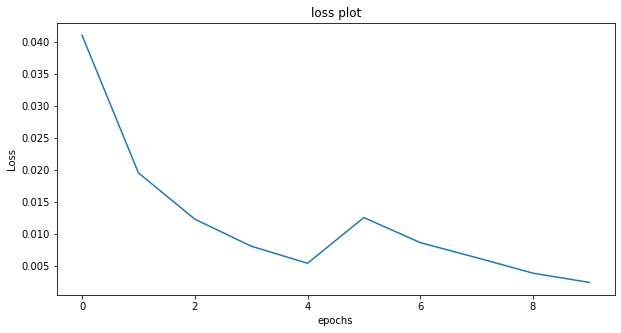

In [35]:
print("train ranger")
error_plot(np.array([x[0] for x in history]).clip(0, 10))

validation ranger


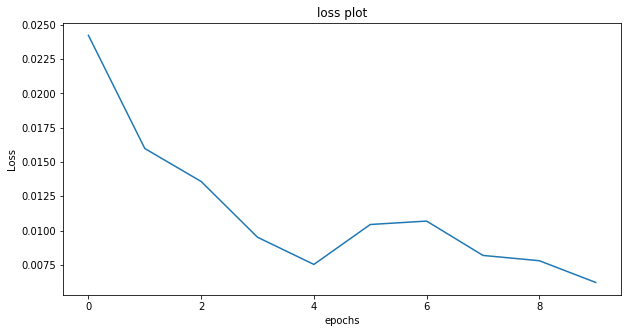

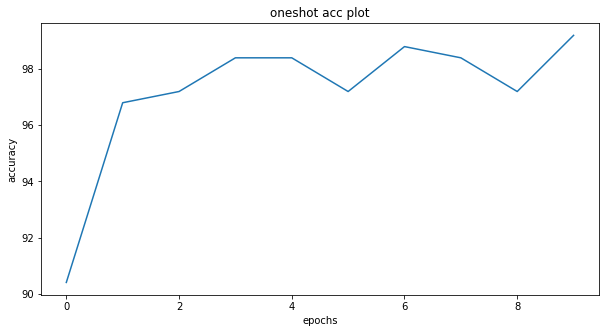

In [36]:
print("validation ranger")
error_plot(np.array([x[1] for x in history]).clip(0, 10))
acc_plot([round(x[2], 3) for x in history])

## To assess the accuracy of the model, run one-short task on 100 images 2000 times

In [37]:
%%time
acc = test_oneshot_func(model, 100, 2000, valid_data, device, verbose=True)

Evaluating model on 2000 random 100 way one-shot learning tasks ... 

Got an average of 98.5% 100 way one-shot learning accuracy 

Wall time: 1min 30s


## Plot 10 random pairs

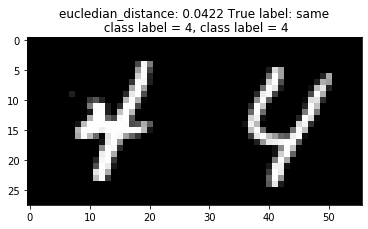

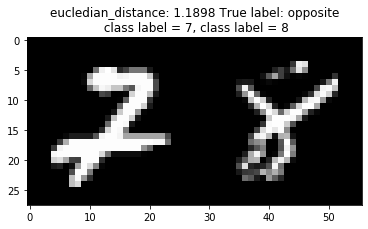

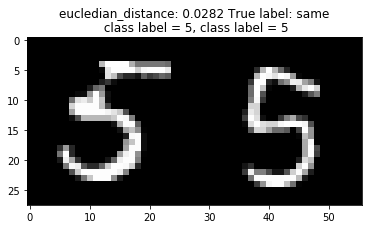

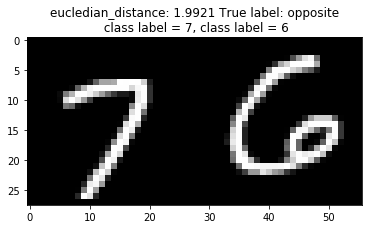

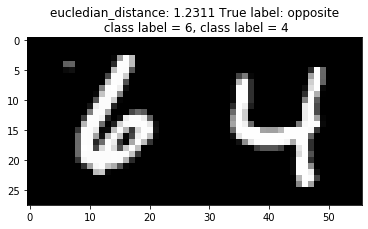

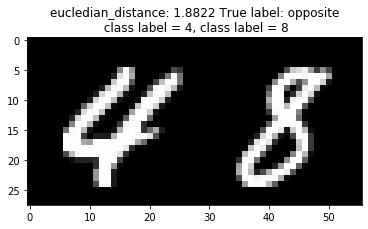

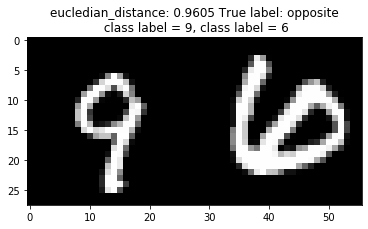

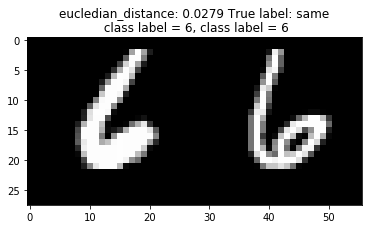

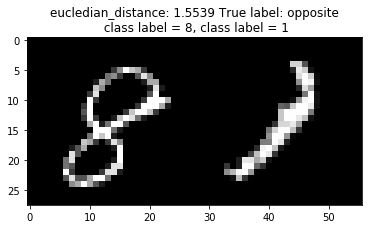

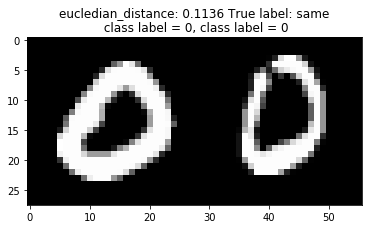

In [38]:
test_dataloader = DataLoader(data["valid"], batch_size=1, shuffle=True)
model.eval()
counter = 0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, batch in enumerate(test_dataloader, 0):
    x0, x1, label, name0, name1 = batch
    concatenated = torch.cat((x0, x1), 3)
    if label == list_0:
        label = "opposite"
    else:
        label = "same"

    if out_mode == "prob_single_neuron":
        prop_of_same = model(x0.to(device), x1.to(device))
        title = "prop_of_same: {:.4f} True label: {}\n {}, {}".format(
            prop_of_same.item(), label, valid_encoder[name0[0]], valid_encoder[name1[0]]
        )
    if out_mode == "L2":
        output1, output2 = model(x0.to(device), x1.to(device))
        eucledian_distance = F.pairwise_distance(output1, output2)
        title = "eucledian_distance: {:.4f} True label: {}\n class {}, class {}".format(
            eucledian_distance.item(),
            label,
            valid_encoder[name0[0]],
            valid_encoder[name1[0]],
        )

    if out_mode == "cross_entropy":
        output = model(x0.to(device), x1.to(device))
        prob = F.softmax(output, dim=1)
        prob_of_same = prob[:, 1]
        title = "prop_of_same: {:.4f} True label: {}\n {}, {}".format(
            prob_of_same.item(), label, valid_encoder[name0[0]], valid_encoder[name1[0]]
        )

    plt.title(title)
    img_tensor_plot(concatenated, inv_normalize=inv_normalize)
    counter = counter + 1
    if counter == 10:
        break